In [1]:
!pip3 install sentencepiece
!pip3 install tf-sentencepiece
!pip3 install matplotlib
#!pip3 install tqdm
#!pip install tensorflow==1.13.1

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/gdrive')
gitDir = "/content/gdrive/My Drive/nlp/"
os.chdir(gitDir + "data/")
print(os.listdir("."))

#sys.path.insert(0,gitDir + "data")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['Kaggle Amazon Fine Food.ipynb', 'Organic Dataset.ipynb', 'cache', 'Amazon Reviews.ipynb', '__pycache__', 'amazon_multilingual.py', 'old', 'Amazon Multilingual.ipynb', 'load_dataset.py', 'tmp.ipynb']


In [3]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
import numpy as np
import tf_sentencepiece

import load_dataset
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import glob, time, datetime
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import f1_score

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

W0610 13:23:24.343289 140170046941056 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1
Version:  1.13.1
Eager mode:  False
Hub version:  0.4.0
GPU is available


## create graph

In [0]:
class Model:
    def __init__(self, data_X, data_Y, architecture, xling=None):
        self.n_class = 39
        self.architecture = architecture
        if xling is None:
          print("Downloading xling...")
          self.xling = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-xling-many/1", trainable=False) 
        else:
          self.xling = xling
        self.data_X = data_X
        self.data_Y = data_Y
        self.create_architecture(data_X, data_Y)
        
        
    def create_architecture(self, data_X, data_Y):
        #y_hot = tf.one_hot(data_Y, depth=self.n_class)
        self.logits = self.forward(data_X)
        
        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=data_Y, logits=self.logits))
        self.train_op = tf.train.AdamOptimizer().minimize(self.loss)

        self.predictions = tf.argmax(self.logits, 1)
        self.labels = data_Y
        #self.acc, self.acc_op = tf.metrics.accuracy(labels=data_Y, predictions=self.predictions)
        
        #a = tf.cast(self.predictions, tf.float64)
        self.accuracy = tf.reduce_mean( tf.cast(tf.equal(self.predictions, tf.cast(data_Y, tf.int64)), tf.float32) )
        
    def forward(self, X):
        output = self.xling(X)
        
        for x in self.architecture:
          if x == "bn":
            output = tf.layers.batch_normalization(output, training=True)
          elif x == "relu" or x == "r":
            output = tf.nn.relu(output)
          elif x == "dropout" or x == "d":
            output = tf.layers.dropout(output)
          else:
            output = tf.layers.dense(output, x)
            
        output = tf.layers.dense(output, self.n_class, name="final_output_prediction")
        
        return output

# train

In [0]:
def trainModel(model, params):

  init_op = tf.group([tf.local_variables_initializer(), tf.global_variables_initializer(), tf.tables_initializer()])
  sess = tf.Session()
  sess.run(init_op)

  loss_hist, acc_hist, val_loss_hist, val_acc_hist = [], [], [], []
  loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch, f1_train_epoch, f1_val_epoch = [], [], [], [], [], []
  train_predictions, train_labels, val_predictions, val_labels = [], [], [], []

  for epoch in tqdm(range(params["epochs"])):
    #print('\nEpoch: {}'.format(epoch + 1))
    train_loss, train_accuracy = 0, 0
    val_loss, val_accuracy = 0, 0  
    counter = 0

    sess.run(train_iterator)

    try:
      #with tqdm(total = params["trainexamples"]) as pbar:
        while True:
          _, a, l, predictions, labels = sess.run([model.train_op, model.accuracy, model.loss, model.predictions, model.labels])
          #print(a,l)
          
          if l >0 and l < 15:
            pass
          else:
            print(l)
            print(counter)
            print(sess.run(model.data_X))
            #print(tf.print(model.data_Y))
                  
                  
          train_loss += l
          train_accuracy += a
          loss_hist.append(l)
          acc_hist.append(a)
          #pbar.set_postfix_str((l, a))
          #pbar.update(params["batchSize"])
          
          train_predictions.extend(predictions)
          train_labels.extend(labels)
          
          counter += 1
    except tf.errors.OutOfRangeError:
       pass
       #print("\tfinished after", counter, "batches.")


    loss_hist_epoch.append(train_loss / counter)
    acc_hist_epoch.append(train_accuracy / counter)
    train_f1 = f1_score(train_labels, train_predictions, average="micro")
    f1_train_epoch.append(train_f1)
    #print('\nEpoch: {}'.format(epoch + 1))
    


    # Validation
    counter = 0
    sess.run(val_iterator) 
    try:
      #with tqdm(total = params["trainexamples"]) as pbar:
        while True:
          a, l, p, labels = sess.run([model.accuracy, model.loss, model.predictions, model.labels])
          val_loss += l
          val_accuracy += a
          val_loss_hist.append(l)
          val_acc_hist.append(a)
          #pbar.set_postfix_str((l, a))
          #pbar.update(params["batchSize"])
          
          val_predictions.extend(p)
          val_labels.extend(labels)
          
          counter += 1
    except tf.errors.OutOfRangeError:
       pass
       #print("\tfinished after", counter, "batches.")


    val_loss_hist_epoch.append(val_loss / counter)
    val_acc_hist_epoch.append(val_accuracy / counter)
    val_f1 = f1_score(val_labels, val_predictions, average="micro")
    f1_val_epoch.append(val_f1)
    print('\tEpoch {}: train_loss: {:.4f}, train_acc: {:.4f}, train_micro-f1: {:.4f} || val_loss: {:.4f}, val_acc: {:.4f}, val_micro-f1: {:.4f}'.format(epoch + 1, loss_hist_epoch[-1], acc_hist_epoch[-1], train_f1, val_loss_hist_epoch[-1], val_acc_hist_epoch[-1], val_f1))
    
  
  sess.close()
  return loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch , val_acc_hist_epoch, f1_train_epoch, f1_val_epoch

In [0]:
import matplotlib.pyplot as plt
import datetime, os

def plotResults(x1, label1, x2, label2, title, path, architecture):
  plt.plot(x1, label=label1)
  plt.plot(x2, label=label2)
  plt.legend()
  plt.title(title)
  #plt.ylim(0,1)
  figpath = path + title + ".png"
  #figpath = figpath.replace()
  #print(figpath)
  plt.savefig(figpath)
  plt.show()
  
  np.save(path + str(architecture) + label1 + ".npy", x1)
  np.save(path + str(architecture) + label2 + ".npy", x2)

saving to: /content/gdrive/My Drive/nlp/blobs/2019-06-10_13-25-26/
./cache/amazon_reviews_multilingual_US_v1_00.tsv.shuffled.csv already exists. Using cached data
./cache/amazon_reviews_multilingual_DE_v1_00.tsv.shuffled.csv already exists. Using cached data
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0610 13:25:39.582801 140170046941056 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use keras.layers.dense instead.


W0610 13:25:40.186778 140170046941056 deprecation.py:323] From <ipython-input-4-1f1d29283722>:40: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use keras.layers.dropout instead.


W0610 13:25:40.208667 140170046941056 deprecation.py:323] From <ipython-input-4-1f1d29283722>:38: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


[False, 400, 'r', 'd', 350, 'r', 'd', 300, 'r', 'd', 250, 'r', 'd', 200, 'r', 'd', 150, 'r', 'd', 100, 'r', 'd', 50, 'r', 'd']


	Epoch 1: train_loss: 1.1106, train_acc: 0.6092, train_micro-f1: 0.6092 || val_loss: 1.0309, val_acc: 0.6074, val_micro-f1: 0.6074
	Epoch 2: train_loss: 0.7991, train_acc: 0.7011, train_micro-f1: 0.6551 || val_loss: 0.9287, val_acc: 0.6711, val_micro-f1: 0.6393
	Epoch 3: train_loss: 0.7430, train_acc: 0.7192, train_micro-f1: 0.6765 || val_loss: 0.7994, val_acc: 0.7262, val_micro-f1: 0.6682
	Epoch 4: train_loss: 0.7128, train_acc: 0.7281, train_micro-f1: 0.6894 || val_loss: 0.8456, val_acc: 0.6936, val_micro-f1: 0.6746
	Epoch 5: train_loss: 0.6853, train_acc: 0.7368, train_micro-f1: 0.6989 || val_loss: 0.8179, val_acc: 0.7023, val_micro-f1: 0.6801
	Epoch 6: train_loss: 0.6599, train_acc: 0.7462, train_micro-f1: 0.7068 || val_loss: 0.8584, val_acc: 0.6875, val_micro-f1: 0.6814
	Epoch 7: train_loss: 0.6399, train_acc: 0.7520, train_micro-f1: 0.7132 || val_loss: 0.8780, val_acc: 0.6932, val_micro-f1: 0.6831
	Epoch 8: train_loss: 0.6146, train_acc: 0.7625, train_micro-f1: 0.7194 || val_loss

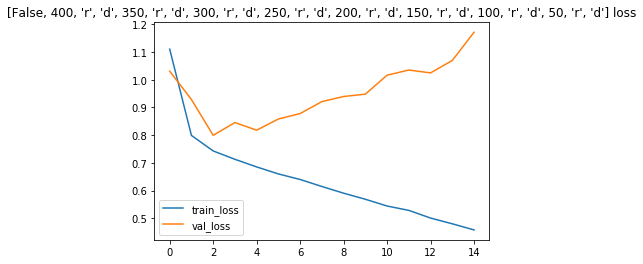

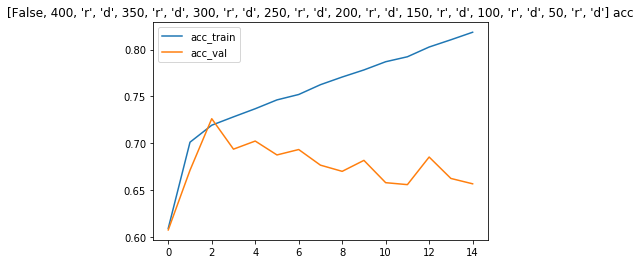

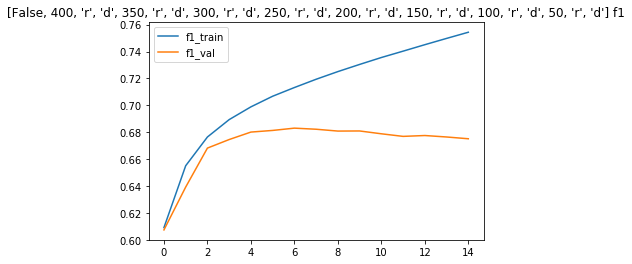

In [9]:
params = {}
params["trainData"] = "US"
params["testData"] = "DE"
params["epochs"] = 15
params["batchSize"] = 512
params["trainexamples"] = 1000 * 100
params["savelog"] = True


architectures = [ [False], [False,150], [False,250], [False, 150, 50], [False, 200, 150, 100, 50], [False, 150, 50], [False, 200, 150, 100, 50] ]

architectures = [ [False, 400, 'r', 'd',
                   350, 'r', 'd',
                   300, 'r', 'd',
                   250, 'r', 'd',
                   200, 'r', 'd',
                   150, 'r', 'd',
                   100, 'r', 'd',
                   50, 'r', 'd'
                   ]]

path="./"
if params["savelog"]==True:
  path = '/content/gdrive/My Drive/nlp/blobs/' + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + "/"
  #path = '/content/gdrive/My Drive/nlp/blobs/' + "us_100k_baseline_search" + "/"
  if os.path.exists(path) == False:
    os.mkdir(path)
  print("saving to:", path)

  f = open(path + "info.txt", "w")
  f.write(str(params)+"\n architectures: "+str(architectures))
  f.close()
  
loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch = [],[],[],[]

for a in architectures:
  tf.reset_default_graph()
  dataset_train = load_dataset.getData(params["trainData"], shuffle=True, batchsize=params["batchSize"])
  dataset_val = load_dataset.getData(params["testData"], shuffle=False, batchsize=params["batchSize"])
  
  dataset_train = dataset_train.take(int(params["trainexamples"]/params["batchSize"]))
  dataset_val = dataset_val.take(int(params["trainexamples"]/params["batchSize"]))
  
  iterator = tf.data.Iterator.from_structure(dataset_train.output_types, dataset_train.output_shapes)
  train_iterator = iterator.make_initializer(dataset_train)
  val_iterator = iterator.make_initializer(dataset_val)
  text_input, label = iterator.get_next()
  
  xling = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-xling/en-de/1", trainable=a[0])
  model = Model(text_input, label, a[1:], xling)
  print(str(a))
  %time loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch, f1_train_epoch, f1_val_epoch = trainModel(model, params)
  print("\t", loss_hist_epoch, acc_hist_epoch, "\n\t", val_loss_hist_epoch, val_acc_hist_epoch)
  plotResults(loss_hist_epoch, "train_loss", val_loss_hist_epoch, "val_loss", str(a)+" loss", path, a)
  plotResults(acc_hist_epoch, "acc_train", val_acc_hist_epoch, "acc_val", str(a)+ " acc", path, a)
  plotResults(f1_train_epoch, "f1_train", f1_val_epoch, "f1_val", str(a) + " f1", path, a)
  
  tf.reset_default_graph()
  del model, xling, dataset_train, dataset_val, iterator,train_iterator,val_iterator,text_input, label
  tf.reset_default_graph()

In [0]:
for f in glob.glob(path+"*loss.npy"):
  x = np.load(f)
  plt.plot(x, label=f[len(path):-4])
plt.legend()
plt.ylim(0,5)
plt.savefig(path+"allloss.png")
plt.show()

for f in glob.glob(path+"*acc*.npy"):
  x = np.load(f)
  plt.plot(x, label=f[len(path):-4])
plt.legend()
plt.ylim(0,1)
plt.savefig(path+"allacc.png")
plt.show()

for f in glob.glob(path+"*f1*.npy"):
  x = np.load(f)
  plt.plot(x, label=f[len(path):-4])
plt.legend()
plt.ylim(0,1)
plt.savefig(path+"allf1.png")
plt.show()